In [1]:
## dependencies

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_categorical_dtype, is_numeric_dtype



In [2]:
## load the dataset

df = pd.read_csv('kick.csv', low_memory=False)
# show all columns information
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseID                         41476 non-null  int64  
 1   PurchaseTimestamp                  41476 non-null  int64  
 2   PurchaseDate                       41476 non-null  object 
 3   Auction                            41432 non-null  object 
 4   VehYear                            41432 non-null  float64
 5   Make                               41432 non-null  object 
 6   Color                              41432 non-null  object 
 7   Transmission                       41432 non-null  object 
 8   WheelTypeID                        41432 non-null  object 
 9   WheelType                          41380 non-null  object 
 10  VehOdo                             41432 non-null  float64
 11  Nationality                        41432 non-null  obj

In [3]:
# Data type

# PurchaseDate -> datetime
df["PurchaseDate"] = pd.to_datetime(df["PurchaseDate"], errors='coerce')

# Int
df["VehYear"] = pd.to_numeric(df["VehYear"], errors='coerce').astype('Int64')
df["VehOdo"] = pd.to_numeric(df["VehOdo"], errors='coerce').astype('Int64')

# float
toFloat_columns = [
    "MMRAcquisitionAuctionAveragePrice", "MMRAcquisitionAuctionCleanPrice",
    "MMRAcquisitionRetailAveragePrice", "MMRAcquisitonRetailCleanPrice",
    "MMRCurrentAuctionAveragePrice", "MMRCurrentAuctionCleanPrice",
    "MMRCurrentRetailAveragePrice", "MMRCurrentRetailCleanPrice",
    "MMRCurrentRetailRatio", "VehBCost"
]
for col in toFloat_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Object -> Categorical var
cat_cols = ["Auction", "Make", "Color", "Transmission", "WheelType", 
            "Nationality", "Size", "VNST"]
df[cat_cols] = df[cat_cols].astype("category")

#  binary
df["IsOnlineSale"] = pd.to_numeric(df["IsOnlineSale"], errors='coerce').astype('Int64')



/var/folders/y7/73c235vj4qj_qnjfklrrmg1w0000gn/T/ipykernel_15950/2468519954.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["PurchaseDate"] = pd.to_datetime(df["PurchaseDate"], errors='coerce')


In [4]:
# data cleaning 

df_processed = df

# 1. 44 missing rows


cols_with_44_missing = [
    'Auction', 'VehYear', 'Make', 'Color', 'Transmission', 'WheelTypeID', 'Nationality',
    'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST', 'WarrantyCost'
]

null_mask = df_processed[cols_with_44_missing].isnull()

# selected features missing
rows_all_missing = null_mask.all(axis=1)

df_processed = df_processed[~rows_all_missing].reset_index(drop=True)


# 2. Missing value + imputation

# 2-1 WheelType (Categorical variables)

s = df_processed['WheelType']
if is_categorical_dtype(s):
    df_processed['WheelType'] = s.cat.add_categories(['Unknown']).fillna('Unknown')


# 2-2 Numerical variable, imputed with median
num_median_cols = [
    'VehYear', 'VehOdo', 'VehBCost', 'WarrantyCost',
    'MMRAcquisitionAuctionCleanPrice',
    'MMRAcquisitonRetailCleanPrice',
    'MMRCurrentAuctionCleanPrice',
    'MMRCurrentRetailCleanPrice',
    'MMRCurrentRetailRatio'
]
for col in num_median_cols:
    df_processed[col] = df_processed[col].fillna(df_processed[col].median())

# 2-3 Numerical variable 'IsOnlineSale' 
df_processed['IsOnlineSale'] = df_processed['IsOnlineSale'].fillna(0)

# 3. Inconsistant features

# 3-1 Transmission
df_processed['Transmission'] = df_processed['Transmission'].str.upper().str.strip()
mode_trans = df_processed.loc[df_processed['Transmission']!='?', 'Transmission'].mode()[0]
df_processed['Transmission'] = df_processed['Transmission'].replace('?', mode_trans)
df_processed['Transmission'] = df_processed['Transmission'].astype("category")
# 3-2 WheelType
df_processed['WheelType'] = df_processed['WheelType'].replace('?', 'Unknown')

# 3-3 TopThreeAmericanName
df_processed['TopThreeAmericanName'] = df_processed['TopThreeAmericanName'].replace('?', 'OTHER')

# 3-4 ForSale  Mostly 'Yes'
df_processed = df_processed.drop(['ForSale'], axis=1)

# 3-5 IsOnlineSale
df_processed['IsOnlineSale'] = df_processed['IsOnlineSale'].apply(lambda x: 1 if x == 1 else 0)

# 3-6 A great number of Null
df_processed = df_processed.drop(['PRIMEUNIT', 'AUCGUART'], axis=1)

# 3-7 color
mode_color = df_processed.loc[df_processed['Color']!='?', 'Color'].mode()[0]
df_processed['Color'] = df_processed['Color'].replace('?', mode_color)
df_processed['Color'] = df_processed['Color'].astype("category")




# 4. Redundant features

drop_cols = [
    'MMRAcquisitionAuctionAveragePrice',
    'MMRCurrentAuctionAveragePrice',
    'MMRCurrentRetailAveragePrice',
    'MMRAcquisitionRetailAveragePrice', # <- drop it 19/08/2025
    'PurchaseID', # identifier
    'WheelTypeID', # Duplicate -> WheelType
    'TopThreeAmericanName', # May  == 'make'
    'PurchaseTimestamp',
    'PurchaseDate'
]
df_processed = df_processed.drop(columns=drop_cols)



df_processed.info()







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41432 entries, 0 to 41431
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Auction                          41432 non-null  category
 1   VehYear                          41432 non-null  Int64   
 2   Make                             41432 non-null  category
 3   Color                            41432 non-null  category
 4   Transmission                     41432 non-null  category
 5   WheelType                        41432 non-null  category
 6   VehOdo                           41432 non-null  Int64   
 7   Nationality                      41432 non-null  category
 8   Size                             41432 non-null  category
 9   MMRAcquisitionAuctionCleanPrice  41432 non-null  float64 
 10  MMRAcquisitonRetailCleanPrice    41432 non-null  float64 
 11  MMRCurrentAuctionCleanPrice      41432 non-null  float64 
 12  MMRC

/var/folders/y7/73c235vj4qj_qnjfklrrmg1w0000gn/T/ipykernel_15950/3623071800.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s):
/var/folders/y7/73c235vj4qj_qnjfklrrmg1w0000gn/T/ipykernel_15950/3623071800.py:53: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_processed['WheelType'] = df_processed['WheelType'].replace('?', 'Unknown')
/var/folders/y7/73c235vj4qj_qnjfklrrmg1w0000gn/T/ipykernel_15950/3623071800.py:69: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.ren

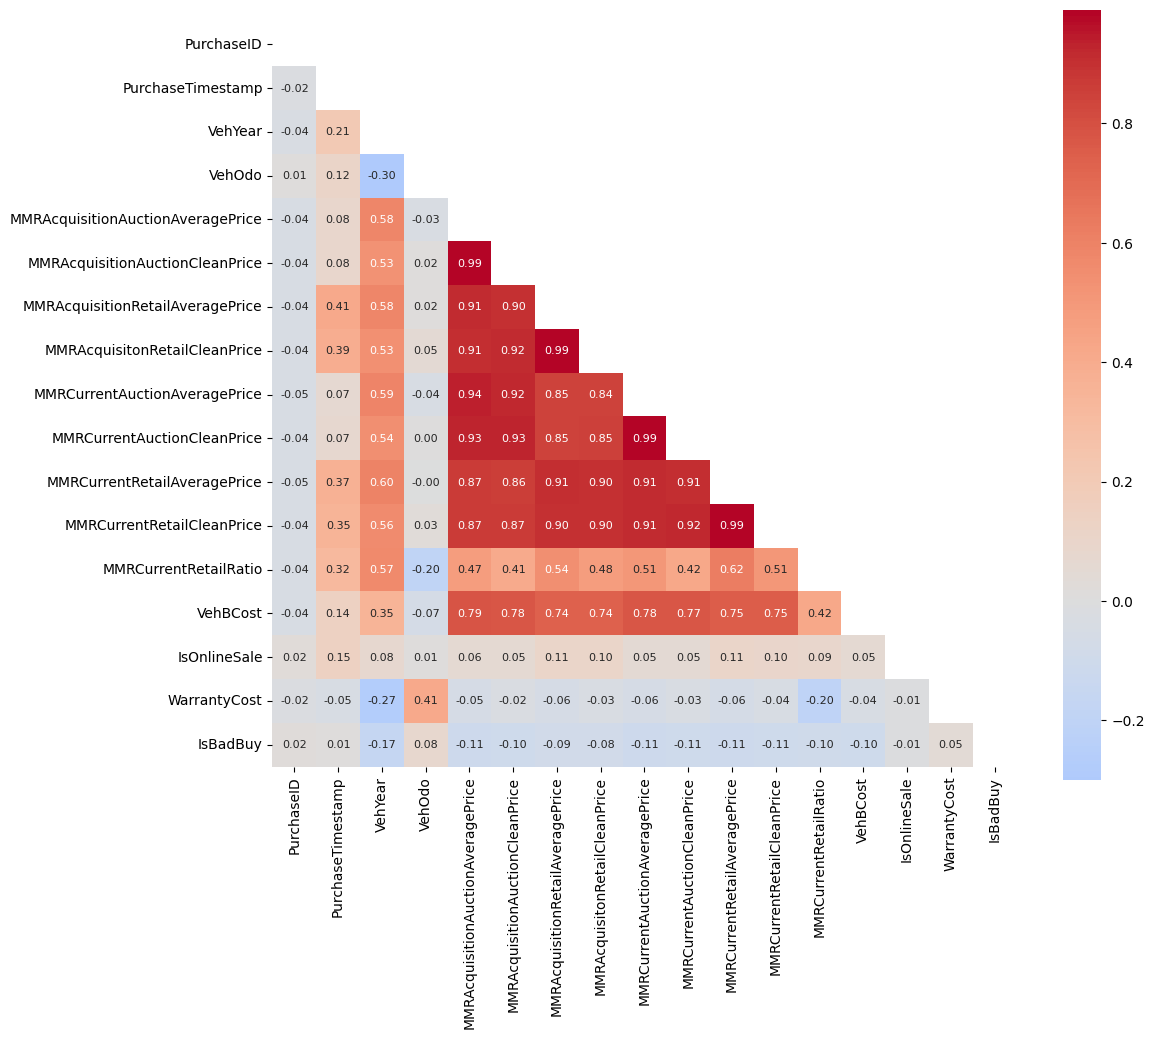

In [5]:
# Compare to df


# coorelation
numeric_df = df.select_dtypes(include=['number'])


corr_matrix = numeric_df.corr()


correlation_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f",
annot_kws={'size': 8}, cmap='coolwarm',
center=0, mask=correlation_mask, square=True)
plt.show()







In [6]:
#Task1 - 3



TARGET = "IsBadBuy"

def summarize_target(df, target=TARGET):
    # Ensure classes appear in 0,1 order even if one is missing
    counts = df[target].value_counts().reindex([0, 1], fill_value=0)
    n = len(df)
    props = counts / n if n > 0 else counts.astype(float)
    out = pd.DataFrame({
        "count": counts,
        "proportion": props,
        "percentage": (props * 100)
    })
    return out

# --- BEFORE / AFTER summaries ---
before = summarize_target(df, TARGET)
after  = summarize_target(df_processed, TARGET)

# Combine for a compact view
combined = pd.concat(
    {"before": before, "after": after},
    axis=1
).round({"before": 4, "after": 4})

# Positive rate (IsBadBuy==1) change
pos_before = before.loc[1, "proportion"]
pos_after  = after.loc[1, "proportion"]
delta = pos_after - pos_before

# Print results
print(f"Dataset size (before): {len(df):,}")
print(f"Dataset size (after) : {len(df_processed):,}\n")

print("Class distribution (counts & proportions):")
print(combined.to_string())




Dataset size (before): 41,476
Dataset size (after) : 41,432

Class distribution (counts & proportions):
         before                        after                      
          count proportion percentage  count proportion percentage
IsBadBuy                                                          
0         36105   0.870503  87.050342  36067   0.870511  87.051072
1          5371   0.129497  12.949658   5365   0.129489  12.948928


In [7]:
# Task 2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder



y = df_processed['IsBadBuy'].values
X = df_processed.drop(['IsBadBuy'],axis=1)
feature_names = X.columns

# one hot -> great number of node
X = pd.get_dummies(X, columns=cat_cols, drop_first=False) 


# order
feature_names = X.columns

random_state = 10
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=random_state
)
# train
model = DecisionTreeClassifier(random_state=random_state)
model.fit(X_train, y_train)
# model parameters
print('*****Model parameters******\n', model.get_params(deep=True))
print('Number of nodes in the trained model:', model.tree_.node_count)
print('Number of rules in the trained model:', model.get_n_leaves())

# Accuracy
print("Training set accuracy:", model.score(X_train, y_train))
print("Testing set accuracy:", model.score(X_test, y_test))

# Precision
y_pred = model.predict(X_test)
print(y_pred)

# metrics
print(classification_report(y_test, y_pred))

# First split & second split variables
first_split_feature = feature_names[model.tree_.feature[0]]
second_split_features = [
    feature_names[model.tree_.feature[model.tree_.children_left[0]]],
    feature_names[model.tree_.feature[model.tree_.children_right[0]]]
]
print("First split:", first_split_feature)
print("Second split:", second_split_features)







# Important Features
def display_feature_importances(model, feature_names, features_to_display=5):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  
    indices = indices[:features_to_display]
    for i in indices:
        print(feature_names[i], ':', importances[i])

display_feature_importances(model, feature_names)




*****Model parameters******
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 10, 'splitter': 'best'}
Number of nodes in the trained model: 6509
Number of rules in the trained model: 3255
Training set accuracy: 1.0
Testing set accuracy: 0.8144006436041834
[1 0 0 ... 1 0 0]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     10820
           1       0.31      0.34      0.32      1610

    accuracy                           0.81     12430
   macro avg       0.60      0.61      0.61     12430
weighted avg       0.82      0.81      0.82     12430

First split: WheelType_Unknown
Second split: ['VehYear', 'Auction_MANHEIM']
WheelType_Unknown : 0.17996699608597516
VehOdo : 0.0823070182686691
VehBCost : 0.075920407144661

In [8]:
# Visualize
from IPython.display import Image, display
from io import StringIO
from sklearn.tree import export_graphviz
import pydot


def visualize_model(model):
    dotfile = StringIO()
    export_graphviz(model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    display(Image(graph[0].create_png()))


visualize_model(model)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Train accuracy: 0.8994896903661816
Test accuracy: 0.8963797264682221
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10820
           1       0.84      0.25      0.38      1610

    accuracy                           0.90     12430
   macro avg       0.87      0.62      0.66     12430
weighted avg       0.89      0.90      0.87     12430

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 100}


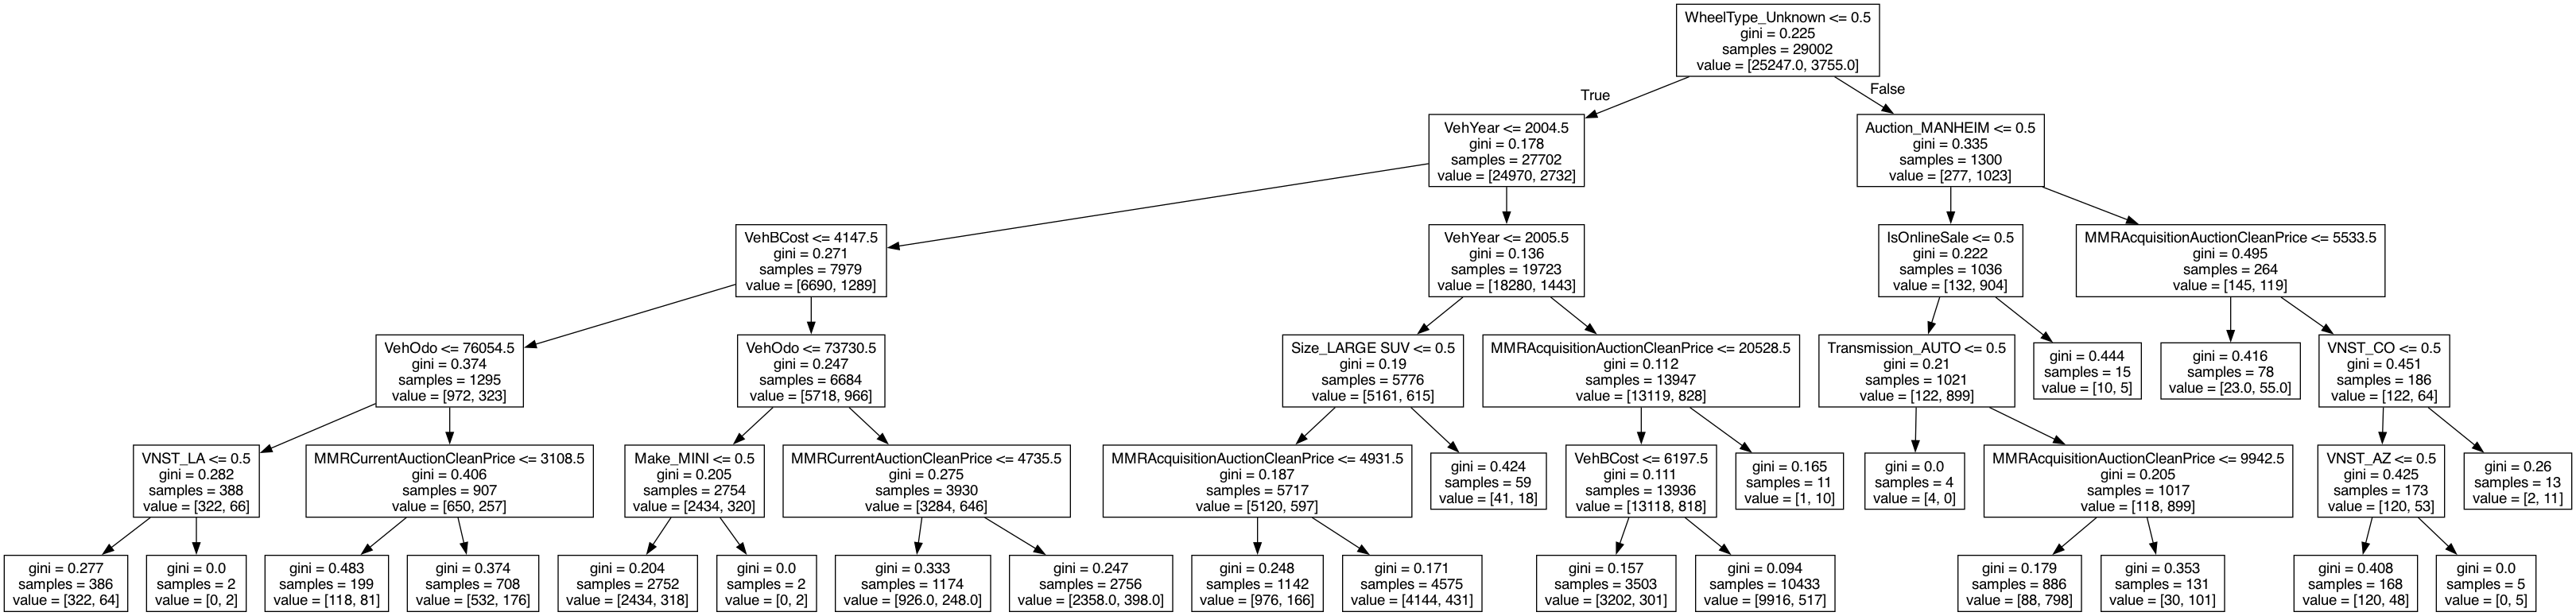

In [9]:
# Grid search

from sklearn.model_selection import GridSearchCV
# Define grid search CV parameters.
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
}

def perform_grid_search(X_train, y_train, X_test, y_test, params, num_folds=10):

    cv = GridSearchCV(param_grid=params,
    estimator=DecisionTreeClassifier(random_state=random_state), cv=num_folds, verbose=1,
    n_jobs=-1)
    cv.fit(X_train, y_train)
    # Display the accuracy of the best fit model.
    print("Train accuracy:", cv.score(X_train, y_train))
    print("Test accuracy:", cv.score(X_test, y_test))
    # Evaluate the best fit model.
    y_pred = cv.predict(X_test)
    print(classification_report(y_test,y_pred))
    # Display parameters of the best model.
    print(cv.best_params_)
    return cv

opt_model = perform_grid_search(X_train, y_train, X_test, y_test, params)
best_model = opt_model.best_estimator_
dt_best_model = best_model


visualize_model(best_model)

In [10]:
# Evaluation

# model parameters
print('*****Model parameters******\n', best_model.get_params(deep=True))
print('Number of nodes in the trained model:', best_model.tree_.node_count)
print('Number of rules in the trained model:', best_model.get_n_leaves())


# Precision
y_pred = best_model.predict(X_test)
print(y_pred)

# metrics
print(classification_report(y_test, y_pred))

# First split & second split variables
first_split_feature = feature_names[best_model.tree_.feature[0]]
second_split_features = [
    feature_names[best_model.tree_.feature[best_model.tree_.children_left[0]]],
    feature_names[best_model.tree_.feature[best_model.tree_.children_right[0]]]
]
print("First split:", first_split_feature)
print("Second split:", second_split_features)

print('Top 5')
display_feature_importances(best_model, feature_names)


*****Model parameters******
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 10, 'splitter': 'best'}
Number of nodes in the trained model: 43
Number of rules in the trained model: 22
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10820
           1       0.84      0.25      0.38      1610

    accuracy                           0.90     12430
   macro avg       0.87      0.62      0.66     12430
weighted avg       0.89      0.90      0.87     12430

First split: WheelType_Unknown
Second split: ['VehYear', 'Auction_MANHEIM']
Top 5
WheelType_Unknown : 0.7868410310874527
VehYear : 0.07148090820662238
Auction_MANHEIM : 0.050072141512106864
MMRAcquisitionAuctionCleanPrice : 0.02597813198121833
V

ROC index on test for default model: 0.6126539878991056
ROC index on test for grid search model: 0.7436733791804916


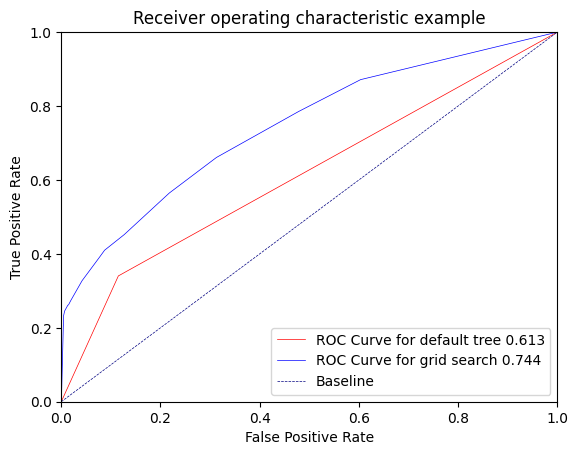

In [11]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


y_pred_proba_dt = model.predict_proba(X_test)
y_pred_proba_dt_small = model.predict_proba(X_test)
y_pred_proba_dt_cv = best_model.predict_proba(X_test)
roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_dt_small = roc_auc_score(y_test, y_pred_proba_dt_small[:, 1])
roc_index_dt_cv = roc_auc_score(y_test, y_pred_proba_dt_cv[:, 1])
print("ROC index on test for default model:", roc_index_dt)
print("ROC index on test for grid search model:", roc_index_dt_cv)



fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_dt_small, tpr_dt_small, thresholds_dt_small = roc_curve(y_test,
y_pred_proba_dt_small[:,1])
fpr_dt_cv, tpr_dt_cv, thresholds_dt_cv = roc_curve(y_test, y_pred_proba_dt_cv[:,1])

# Plot
plt.plot(fpr_dt, tpr_dt, label='ROC Curve for default tree {:.3f}'.format(roc_index_dt),
color='red', lw=0.5)
plt.plot(fpr_dt_cv, tpr_dt_cv, label='ROC Curve for grid search {:.3f}'.format(roc_index_dt_cv), color='blue', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, label='Baseline', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


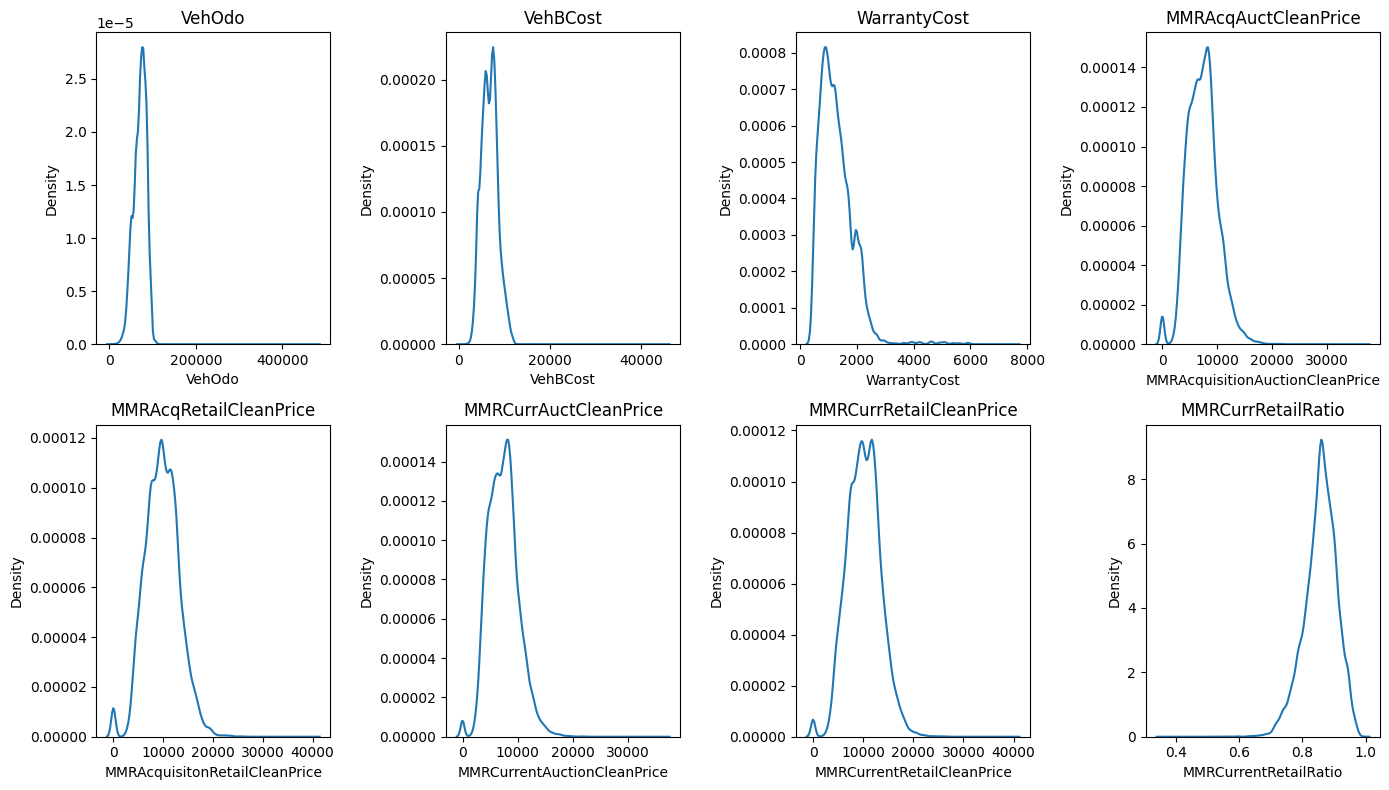

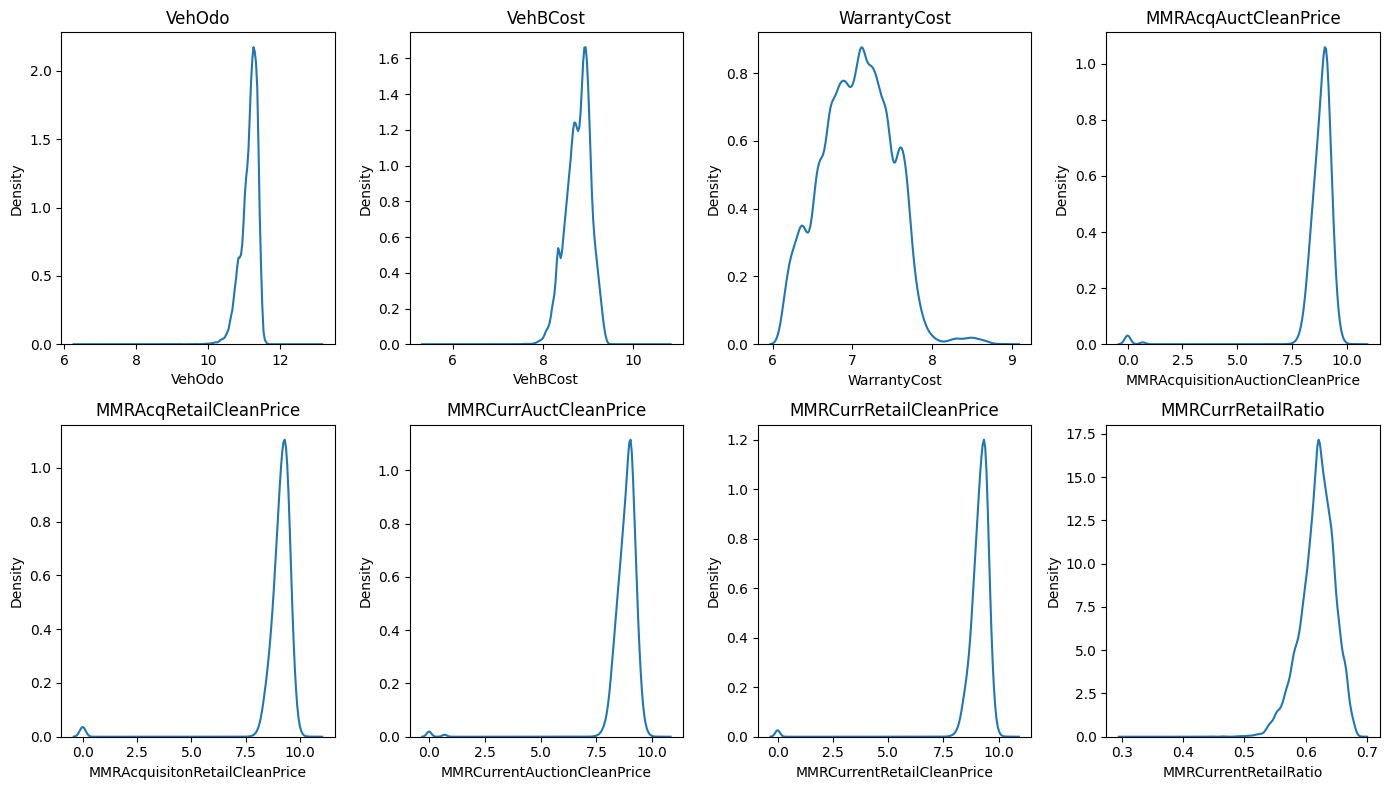

Before scaling
-------------
#0 Variable VehYear: min 2001, max 2010, mean 2005.36 and std dev 1.73
#1 Variable VehOdo: min 6.359573868672378, max 13.082468036741073, mean 11.15 and std dev 0.23
#2 Variable MMRAcquisitionAuctionCleanPrice: min 0.0, max 10.51058652847062, mean 8.74 and std dev 1.04
#3 Variable MMRAcquisitonRetailCleanPrice: min 0.0, max 10.600078795498629, mean 9.03 and std dev 1.07
#4 Variable MMRCurrentAuctionCleanPrice: min 0.0, max 10.504492031531843, mean 8.79 and std dev 0.82
#5 Variable MMRCurrentRetailCleanPrice: min 0.0, max 10.594056412081272, mean 9.11 and std dev 0.84
#6 Variable MMRCurrentRetailRatio: min 0.30606509700039, max 0.6891968618148455, mean 0.62 and std dev 0.03
#7 Variable VehBCost: min 5.420534999272286, max 10.724808046819057, mean 8.78 and std dev 0.27
#8 Variable WarrantyCost: min 6.137727054086234, max 8.92252495730139, mean 7.06 and std dev 0.43
After scaling
-------------
#0 Variable VehYear: min -2.5157696322105014, max 2.680567772714108

In [12]:
# Task 3

#  3 - 1 

# Ref tut
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


scaler = StandardScaler()

y = df_processed['IsBadBuy'].values
X = df_processed.drop(['IsBadBuy'],axis=1)


X = pd.get_dummies(X, columns=cat_cols, drop_first=False) 

# Only include 'number' var
num_candidates = X.select_dtypes(include=['int64','float64','Int64']).columns.tolist()

#  Remove binary var
exclude = {"IsOnlineSale"}
numerical_columns = [c for c in num_candidates if c not in exclude]

# create new train/validation dataset
random_state = 10
test_set_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size,
stratify=y, random_state=random_state)



#  3 - 1 - 1 :  Visualising before any log/scale

def plot_skewed_columns(df):
    f, axes = plt.subplots(2, 4, figsize=(14, 8), sharex=False)
    sns.kdeplot(df['VehOdo'].dropna(), ax=axes[0,0]); axes[0,0].set_title("VehOdo")
    sns.kdeplot(df['VehBCost'].dropna(), ax=axes[0,1]); axes[0,1].set_title("VehBCost")
    sns.kdeplot(df['WarrantyCost'].dropna(), ax=axes[0,2]); axes[0,2].set_title("WarrantyCost")
    sns.kdeplot(df['MMRAcquisitionAuctionCleanPrice'].dropna(), ax=axes[0,3]); axes[0,3].set_title("MMRAcqAuctCleanPrice")
    sns.kdeplot(df['MMRAcquisitonRetailCleanPrice'].dropna(), ax=axes[1,0]); axes[1,0].set_title("MMRAcqRetailCleanPrice")
    sns.kdeplot(df['MMRCurrentAuctionCleanPrice'].dropna(), ax=axes[1,1]); axes[1,1].set_title("MMRCurrAuctCleanPrice")
    sns.kdeplot(df['MMRCurrentRetailCleanPrice'].dropna(), ax=axes[1,2]); axes[1,2].set_title("MMRCurrRetailCleanPrice")
    sns.kdeplot(df['MMRCurrentRetailRatio'].dropna(), ax=axes[1,3]); axes[1,3].set_title("MMRCurrRetailRatio")
    plt.tight_layout()
    plt.show()

plot_skewed_columns(X_train)


# 3 - 1 - 2 : Log transformation first
columns_to_transform = [
    'VehOdo', 'VehBCost', 'WarrantyCost',
    'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice',
    'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio'
]

for col in columns_to_transform:
    X_train[col] = X_train[col].apply(lambda x: x+1)
    X_train[col] = X_train[col].apply(np.log)

    X_test[col] = X_test[col].apply(lambda x: x+1) 
    X_test[col] = X_test[col].apply(np.log)

plot_skewed_columns(X_train)

#  3 - 1 - 3 Standardisation after log 

# mapping
X_train_numerical = X_train[numerical_columns].to_numpy()
X_test_numerical  = X_test[numerical_columns].to_numpy()

print("Before scaling\n-------------")
for i, colname in enumerate(numerical_columns):
    col = X_train_numerical[:, i] 
    var_name = numerical_columns[i]
    print("#{} Variable {}: min {}, max {}, mean {:.2f} and std dev {:.2f}".format(i,var_name,
min(col), max(col), np.mean(col), np.std(col)))

# Ensure Columns Are Floats Before Scaling, otherwise it may cause some errors
X_train[numerical_columns] = X_train[numerical_columns].astype('float64')
X_test[numerical_columns] = X_test[numerical_columns].astype('float64')

X_train_numerical = scaler.fit_transform(X_train_numerical)
X_test_numerical = scaler.transform(X_test_numerical)

print("After scaling\n-------------")

for i, var_name in enumerate(numerical_columns):
    col = X_train_numerical[:, i] 
    var_name = numerical_columns[i]
    print("#{} Variable {}: min {}, max {}, mean {:.2f} and std dev {:.2f}".format(i,var_name,
min(col), max(col), np.mean(col), np.std(col)))

# put it back 
X_train.loc[:, numerical_columns] = X_train_numerical
X_test.loc[:, numerical_columns]  = X_test_numerical


In [13]:
#  3 - 2 




from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report 




params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params,
estimator=LogisticRegression(random_state=random_state,  max_iter=1000), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)
# test the best model
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))
# print parameters of the best model
print(cv.best_params_)




Train accuracy: 0.8971105441004069
Test accuracy: 0.8942075623491552
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10820
           1       0.79      0.25      0.38      1610

    accuracy                           0.89     12430
   macro avg       0.84      0.62      0.66     12430
weighted avg       0.88      0.89      0.87     12430

{'C': 10}


In [14]:
# 3 - 2 - c
best_model = cv.best_estimator_  
coefs = best_model.coef_.ravel()
feature_names = X_train.columns

print(feature_names)

# 3 - 2 -d
print('=================')

coef = best_model.coef_[0]

indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

indices = indices[:5]
for i in indices:
    print(feature_names[i], ':', coef[i])



Index(['VehYear', 'VehOdo', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'VehBCost',
       'IsOnlineSale', 'WarrantyCost',
       ...
       'VNST_OK', 'VNST_OR', 'VNST_PA', 'VNST_SC', 'VNST_TN', 'VNST_TX',
       'VNST_UT', 'VNST_VA', 'VNST_WA', 'VNST_WV'],
      dtype='object', length=115)
WheelType_Unknown : 2.676455998070095
Color_OTHER : -1.7429328447631955
MMRAcquisitionAuctionCleanPrice : -1.5134527090866388
MMRAcquisitonRetailCleanPrice : 1.4708835290095106
VNST_KY : -1.3443540468446844


In [15]:
#  3 - 3 - 1

from sklearn.feature_selection import RFECV
rfe = RFECV(estimator = LogisticRegression(random_state=random_state), cv=10)
# run the RFECV
rfe.fit(X_train, y_train)
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)


Original feature set 115
Number of features after elimination 82


In [16]:

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}
rfe_cv = GridSearchCV(param_grid=params,
estimator=LogisticRegression(random_state=random_state, max_iter=1000), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_sel, y_train)
# test the best model
print("Train accuracy:", rfe_cv.score(X_train_sel, y_train))
print("Test accuracy:", rfe_cv.score(X_test_sel, y_test))
y_pred = rfe_cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))
# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.8971795048617337
Test accuracy: 0.8941271118262268
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10820
           1       0.78      0.25      0.38      1610

    accuracy                           0.89     12430
   macro avg       0.84      0.62      0.66     12430
weighted avg       0.88      0.89      0.87     12430

{'C': 10}


In [17]:
# Best Decision tree + Regression

from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(dt_best_model, prefit=True)
X_train_sel_model = selectmodel.transform(X_train.values)
X_test_sel_model = selectmodel.transform(X_test.values)
print(X_train_sel_model.shape)



params = {'C': [pow(10, x) for x in range(-6, 4)]}
cv_sel_model = GridSearchCV(param_grid=params,
estimator=LogisticRegression(random_state=random_state), cv=10)
cv_sel_model.fit(X_train_sel_model, y_train)
print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))
# test the best model
y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))
# print parameters of the best model
print(cv_sel_model.best_params_)


(29002, 7)
Train accuracy: 0.8961450934418316
Test accuracy: 0.8935639581657281
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10820
           1       0.77      0.25      0.38      1610

    accuracy                           0.89     12430
   macro avg       0.84      0.62      0.66     12430
weighted avg       0.88      0.89      0.87     12430

{'C': 0.1}


In [18]:
# 3-3-b

selected_features_rfecv = X_train.columns[rfe.support_]
print("RFECV selected features (total={}):".format(len(selected_features_rfecv)))
print(selected_features_rfecv.tolist())


selected_features_tree = X_train.columns[selectmodel.get_support()]
print("Decision Tree selected features (total={}):".format(len(selected_features_tree)))
print(selected_features_tree.tolist())

RFECV selected features (total=82):
['VehYear', 'VehOdo', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice', 'VehBCost', 'IsOnlineSale', 'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER', 'Make_ACURA', 'Make_BUICK', 'Make_CHEVROLET', 'Make_GMC', 'Make_HONDA', 'Make_HYUNDAI', 'Make_INFINITI', 'Make_ISUZU', 'Make_JEEP', 'Make_KIA', 'Make_LEXUS', 'Make_LINCOLN', 'Make_MERCURY', 'Make_MINI', 'Make_MITSUBISHI', 'Make_NISSAN', 'Make_PONTIAC', 'Make_SCION', 'Make_SUBARU', 'Make_SUZUKI', 'Make_TOYOTA', 'Make_VOLKSWAGEN', 'Make_VOLVO', 'Color_BROWN', 'Color_NOT AVAIL', 'Color_OTHER', 'Color_PURPLE', 'Color_YELLOW', 'Transmission_AUTO', 'Transmission_MANUAL', 'WheelType_Alloy', 'WheelType_Covers', 'WheelType_Special', 'WheelType_Unknown', 'Nationality_AMERICAN', 'Nationality_OTHER', 'Nationality_OTHER ASIAN', 'Nationality_TOP LINE ASIAN', 'Nationality_USA', 'Size_COMPACT', 'Size_LARGE', 'Size_LARGE SUV', 'Size_MEDIUM

ROC index on test for  Logistic (all features): 0.7648379467514723
ROC index on test for Logistic (RFE): 0.7643113741518468
ROC index on test for Logistic (DT-Select): 0.7508868440086796


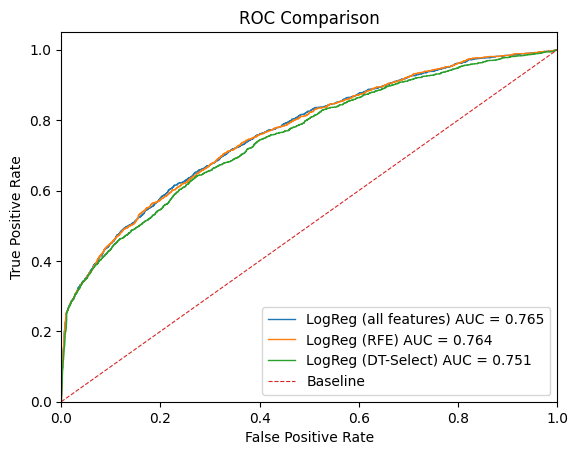

In [19]:
# 3-4
#  best_model rfe_cv cv_sel_model

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

curves = []

# Logistic (all features)
prob_lr_all = best_model.predict_proba(X_test)[:, 1]
auc_lr_all = roc_auc_score(y_test, prob_lr_all)
fpr_lr_all, tpr_lr_all, _ = roc_curve(y_test, prob_lr_all)
curves.append(('LogReg (all features)', fpr_lr_all, tpr_lr_all, auc_lr_all))

# Logistic (RFE)
prob_lr_rfe = rfe_cv.best_estimator_.predict_proba(X_test_sel)[:, 1]
auc_lr_rfe = roc_auc_score(y_test, prob_lr_rfe)
fpr_lr_rfe, tpr_lr_rfe, _ = roc_curve(y_test, prob_lr_rfe)
curves.append(('LogReg (RFE)', fpr_lr_rfe, tpr_lr_rfe, auc_lr_rfe))

# Logistic (DT-Select)
prob_lr_dt = cv_sel_model.best_estimator_.predict_proba(X_test_sel_model)[:, 1]
auc_lr_dt = roc_auc_score(y_test, prob_lr_dt)
fpr_lr_dt, tpr_lr_dt, _ = roc_curve(y_test, prob_lr_dt)
curves.append(('LogReg (DT-Select)', fpr_lr_dt, tpr_lr_dt, auc_lr_dt))

print("ROC index on test for  Logistic (all features):", auc_lr_all)
print("ROC index on test for Logistic (RFE):", auc_lr_rfe)
print("ROC index on test for Logistic (DT-Select):", auc_lr_dt)

# visualizing
plt.figure()
for label, fpr, tpr, auc_ in curves:
    plt.plot(fpr, tpr, lw=1.0, label=f'{label} AUC = {auc_:.3f}')
plt.plot([0, 1], [0, 1], lw=0.8, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison')
plt.legend(loc="lower right")
plt.show()


In [20]:
# Task 4 

# First
# 4 - 2  - a

from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
# hide warnings in subprocesses, required because we use multiple n_jobs
import os
os.environ["PYTHONWARNINGS"] = "ignore"
params = {'hidden_layer_sizes': [(x,) for x in range(5, 86, 20)],
          'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
          'activation':["relu", "tanh"] }
cv_1 = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), return_train_score=True, cv=10,n_jobs=-1)
cv_1.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(5,), (25,), (45,), (65,),
                                                (85,)]},
             return_train_score=True)

In [21]:
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([ 6.88837469, 16.09128883, 19.14973133, 21.54938588, 27.55564415,
        4.60448096, 13.37189758, 18.72481573, 21.47643592, 26.41029336,
        4.8890393 , 13.88377388, 19.86561894, 22.89613752, 27.81324489,
        3.39023497,  9.80014341, 17.82290502, 16.79354591, 25.86628461,
        6.48839545, 13.54216661, 18.24968774, 23.8176616 , 28.34942369,
        6.66917562, 16.42199318, 20.90691149, 23.97244856, 27.55478158,
        4.63543799, 13.83457119, 20.75650864, 22.42567163, 25.85892878,
        4.05151486,  9.29922683, 12.88432648, 15.74268675, 16.95789838]), 'std_fit_time': array([1.51460655, 1.20779332, 0.74339835, 2.05591242, 3.14347966,
       0.92316021, 3.00851487, 4.48443521, 4.19804692, 2.77640607,
       0.62997876, 1.52766428, 1.06482876, 0.59127289, 2.1943876 ,
       0.32797106, 3.72988892, 3.42662912, 2.73548048, 3.18037257,
       0.78499085, 0.88902544, 2.02300562, 2.94992586, 1.67854666,
       1.47538745, 3.01479646, 1.56613894, 0.87735714

In [22]:
# Task 4 

# Second
# 4 - 2  - a 

from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report



import os
# os.environ["PYTHONWARNINGS"] = "ignore"
params = {'hidden_layer_sizes': [(h,) for h in [ 58 ,63, 68, 73, 78]],
          'alpha': [ 3e-2 ,1e-1, 3e-1, 1.0],
          'activation':["relu", "tanh"] }
cv_1 = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), return_train_score=True, cv=10,n_jobs=-1)
cv_1.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.03, 0.1, 0.3, 1.0],
                         'hidden_layer_sizes': [(58,), (63,), (68,), (73,),
                                                (78,)]},
             return_train_score=True)

In [23]:
result_set = cv_1.cv_results_
print(result_set)


{'mean_fit_time': array([19.5222101 , 23.9423327 , 24.92404017, 25.1125766 , 23.63272066,
       12.7620873 , 15.26981595, 16.19954789, 18.27634139, 19.70732648,
        6.56893582,  6.4555968 ,  6.68229506,  7.58971114,  7.30564282,
        4.20854797,  4.77522538,  5.90889308,  5.16723301,  6.12981548,
       24.76613679, 25.25530448, 22.89141531, 24.6533772 , 26.0233736 ,
       14.88639133, 13.61964827, 15.34594936, 17.56804879, 18.86484601,
       10.57283349,  8.5145009 ,  9.50701184,  9.55390582, 12.71508188,
        4.17122607,  4.33496673,  4.55481796,  5.16125722,  4.2418381 ]), 'std_fit_time': array([0.52274016, 1.60238325, 1.45248194, 2.25439579, 2.75922048,
       1.90818093, 2.99719769, 2.46127045, 2.08253952, 3.22971441,
       1.51774787, 0.98257596, 1.90072489, 1.422371  , 1.16072523,
       0.52376569, 0.66038341, 0.86254482, 1.03867725, 1.88114402,
       1.03456874, 2.05756788, 1.05675383, 1.06928464, 0.88964404,
       2.02689063, 3.25353531, 2.31360881, 4.41561229

In [24]:
#  4 - 2 - b
print("Train accuracy:", cv_1.score(X_train, y_train))
print("Test accuracy:", cv_1.score(X_test, y_test))
y_pred = cv_1.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv_1.best_params_)




Train accuracy: 0.8980070339976554
Test accuracy: 0.8942880128720837
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10820
           1       0.79      0.25      0.38      1610

    accuracy                           0.89     12430
   macro avg       0.84      0.62      0.66     12430
weighted avg       0.88      0.89      0.87     12430

{'activation': 'relu', 'alpha': 0.3, 'hidden_layer_sizes': (73,)}


In [25]:
# 4 - 2 - c
best_est = cv_1.best_estimator_
print("Best params:", cv_1.best_params_)
print("n_iter_  of  max_iter:", best_est.n_iter_, " of ", best_est.max_iter)

Best params: {'activation': 'relu', 'alpha': 0.3, 'hidden_layer_sizes': (73,)}
n_iter_  of  max_iter: 45  of  200


In [26]:
# 4-3 Best DT + MLP

# First pass
X_train_sel_model
X_test_sel_model

params = {'hidden_layer_sizes': [(h,) for h in [ 58 ,63, 68, 73, 78]],
          'alpha': [ 3e-2 ,1e-1, 3e-1, 1.0],
          'activation':["relu", "tanh"] }


cv_sel_model = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_sel_model.fit(X_train_sel_model, y_train)
print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))
y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))
print(cv_sel_model.best_params_)

Train accuracy: 0.8979380732363286
Test accuracy: 0.8953338696701528
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10820
           1       0.83      0.24      0.38      1610

    accuracy                           0.90     12430
   macro avg       0.86      0.62      0.66     12430
weighted avg       0.89      0.90      0.87     12430

{'activation': 'relu', 'alpha': 0.03, 'hidden_layer_sizes': (58,)}


In [27]:
# Second pass

# 4-3 Best DT + MLP

# second pass
print(X_train_sel_model.shape)

params = {'hidden_layer_sizes': [(h,) for h in [ 75, 78, 81, 84, 87]],
          'alpha': [ 5e-2, 7e-2 ,1e-1, 2e-1],
          'activation':["relu", "tanh"] }


cv_sel_model = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_sel_model.fit(X_train_sel_model, y_train)
print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))
y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))
print(cv_sel_model.best_params_)

(29002, 7)
Train accuracy: 0.8979725536169919
Test accuracy: 0.8954143201930812
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10820
           1       0.83      0.24      0.38      1610

    accuracy                           0.90     12430
   macro avg       0.86      0.62      0.66     12430
weighted avg       0.89      0.90      0.87     12430

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (84,)}


In [28]:
# 4 - 3 - c
best_est_sel = cv_sel_model.best_estimator_
print("Best params:", cv_sel_model.best_params_)
print("n_iter_  of  max_iter:", best_est_sel.n_iter_, " of ", best_est_sel.max_iter)

Best params: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (84,)}
n_iter_  of  max_iter: 42  of  200


ROC AUC - NN (all features): 0.7693141869783354
ROC AUC - NN (DT-selected): 0.7578338365805215


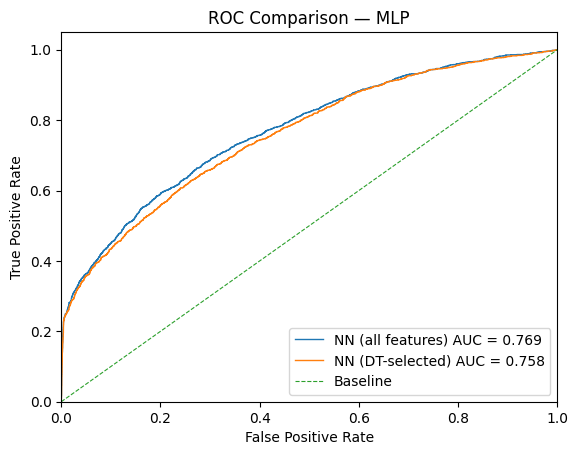

In [29]:
# 4 - 4

curves = []

# MLP (all features) 
proba_all = cv_1.best_estimator_.predict_proba(X_test)[:, 1]
auc_all = roc_auc_score(y_test, proba_all)
fpr_all, tpr_all, _ = roc_curve(y_test, proba_all)
curves.append(('NN (all features)', fpr_all, tpr_all, auc_all))

# MLP (DT-selected features) 
proba_sel = cv_sel_model.best_estimator_.predict_proba(X_test_sel_model)[:, 1]
auc_sel = roc_auc_score(y_test, proba_sel)
fpr_sel, tpr_sel, _ = roc_curve(y_test, proba_sel)
curves.append(('NN (DT-selected)', fpr_sel, tpr_sel, auc_sel))

print("ROC AUC - NN (all features):", auc_all)
print("ROC AUC - NN (DT-selected):", auc_sel)

# Visualize
plt.figure()
for label, fpr, tpr, auc_ in curves:
    plt.plot(fpr, tpr, lw=1.0, label=f'{label} AUC = {auc_:.3f}')
plt.plot([0, 1], [0, 1], lw=0.8, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Comparison — MLP')
plt.legend(loc='lower right')
plt.show()

AUC — DT (tuned): 0.7436733791804916
AUC — Logistic (all): 0.7648379467514723
AUC — NN (all): 0.7693141869783354


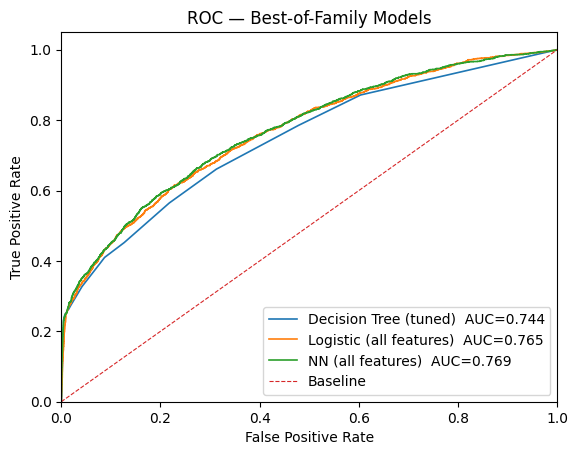

In [30]:
# Task 5

dt_best = dt_best_model          # tuned DT (grid search)
lr_best = best_model             # Logistic (all features)
mlp_best = cv_1.best_estimator_  # MLP (all features)


random_state = 10
DT_X_train, DT_X_test, DT_y_train, DT_y_test = train_test_split(
    X, y, test_size=0.3, stratify=y ,random_state=random_state
)


curves = []
# Decision Tree (tuned) 
prob_dt = dt_best.predict_proba(DT_X_test)[:, 1]
auc_dt = roc_auc_score(DT_y_test, prob_dt)
fpr_dt, tpr_dt, _ = roc_curve(DT_y_test, prob_dt)
curves.append(('Decision Tree (tuned)', fpr_dt, tpr_dt, auc_dt))

# Logistic (all features) + log transformation, standardzied
prob_lr_all = lr_best.predict_proba(X_test)[:, 1]
auc_lr_all = roc_auc_score(y_test, prob_lr_all)
fpr_lr_all, tpr_lr_all, _ = roc_curve(y_test, prob_lr_all)
curves.append(('Logistic (all features)', fpr_lr_all, tpr_lr_all, auc_lr_all))

# MLP (all features)  + log transformation, standardzied
prob_mlp_all = mlp_best.predict_proba(X_test)[:, 1]
auc_mlp_all = roc_auc_score(y_test, prob_mlp_all)
fpr_mlp_all, tpr_mlp_all, _ = roc_curve(y_test, prob_mlp_all)
curves.append(('NN (all features)', fpr_mlp_all, tpr_mlp_all, auc_mlp_all))

print("AUC — DT (tuned):", auc_dt)
print("AUC — Logistic (all):", auc_lr_all)
print("AUC — NN (all):", auc_mlp_all)

plt.figure()
for label, fpr, tpr, auc_ in curves:
    plt.plot(fpr, tpr, lw=1.2, label=f'{label}  AUC={auc_:.3f}')
plt.plot([0, 1], [0, 1], '--', lw=0.8, label='Baseline')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC — Best-of-Family Models')
plt.legend(loc='lower right')
plt.show()